1. **Carga de imágenes**: El código recorre las carpetas que contienen las imágenes, cada carpeta es una clase. Usa Image.open(img_path).convert('L') para abrir las imágenes y convertirlas a escala de grises. Luego, con img.resize(img_size), se redimensionan a 48x48 píxeles.

2. **Etiquetado**: El código asigna etiquetas numéricas a cada clase utilizando un diccionario class_to_idx. Este diccionario se crea con class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}, donde a cada nombre de clase se le asigna un número.

3. **Almacenamiento de imágenes y etiquetas**: Las imágenes redimensionadas se convierten en arrays numpy con img_array = np.array(img), y luego se almacenan en la lista data. Las etiquetas de clase también se almacenan en labels usando labels.append(class_to_idx[class_name]).

4. **Conversión a arrays de numpy**: Una vez que todas las imágenes y etiquetas se han procesado, las listas data y labels se convierten en arrays numpy, que son estructuras más eficientes para el procesamiento.

In [1]:
import os
import numpy as np
from PIL import Image

# Ruta del directorio que contiene las imágenes
dataset_dir = r"D:\UNIVERSIDAD\6to Semestre\IA\datasets\Expresiones\train"  # Cambia esto si el dataset no está en la misma carpeta que el script

# Tamaño al que se redimensionarán las imágenes (por ejemplo, 48x48)
img_size = (48, 48)

# Listas para almacenar las imágenes y las etiquetas
data = []
labels = []

# Mapeo de clases a etiquetas numéricas
class_names = os.listdir(dataset_dir)
class_names.sort()  # Ordenamos para que las clases sean consistentes
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

# Recorremos cada carpeta/clase en el directorio de entrenamiento
for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    
    # Comprobamos si es una carpeta
    if os.path.isdir(class_dir):
        # Recorremos todas las imágenes en la carpeta de la clase
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            
            # Abrimos la imagen, la redimensionamos y la convertimos a un array de numpy
            try:
                img = Image.open(img_path).convert('L')  # Convertimos a escala de grises (1 canal)
                img = img.resize(img_size)  # Redimensionamos
                img_array = np.array(img)  # Convertimos a array de numpy

                # Añadimos la imagen y la etiqueta a las listas
                data.append(img_array)
                labels.append(class_to_idx[class_name])
            except Exception as e:
                print(f"No se pudo procesar la imagen {img_path}: {e}")

# Convertimos las listas a arrays de numpy
data = np.array(data)
labels = np.array(labels)

# Verificamos las dimensiones del dataset
print(f"Dimensiones de los datos: {data.shape}")  # Debería ser (n_imágenes, 48, 48)
print(f"Dimensiones de las etiquetas: {labels.shape}")


Dimensiones de los datos: (28273, 48, 48)
Dimensiones de las etiquetas: (28273,)


In [2]:
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Verificar las dimensiones de los conjuntos divididos
print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Dimensiones de y_train: {y_train.shape}")
print(f"Dimensiones de y_test: {y_test.shape}")


Dimensiones de X_train: (22618, 48, 48)
Dimensiones de X_test: (5655, 48, 48)
Dimensiones de y_train: (22618,)
Dimensiones de y_test: (5655,)


# Aplanar Imágenes

La línea de código `X_train.reshape(X_train.shape[0], -1)` transforma cada imagen de entrenamiento, que originalmente está en el formato `(n_samples, height, width)`, a `(n_samples, height * width)`. Esto significa que cada imagen de **48x48** se convierte en un solo vector de tamaño **48 * 48 = 2304**.

- El primer valor `X_train.shape[0]` representa el número de muestras (imágenes).
- El valor `-1` le indica a `reshape` que ajuste automáticamente el tamaño para mantener la integridad de los datos (en este caso, 2304).

In [3]:
# Aplanar las imágenes para convertirlas de (n_samples, height, width) a (n_samples, height * width)
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # (n_samples, 48 * 48)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)  # (n_samples, 48 * 48)

# Comprobamos las nuevas dimensiones
print(f"Dimensiones de X_train aplanado: {X_train_flattened.shape}")
print(f"Dimensiones de X_test aplanado: {X_test_flattened.shape}")


Dimensiones de X_train aplanado: (22618, 2304)
Dimensiones de X_test aplanado: (5655, 2304)


In [4]:
# Normalizar los datos
X_train_normalized = X_train_flattened / 255.0
X_test_normalized = X_test_flattened / 255.0

In [5]:
print(X_train_normalized.shape)
print(X_test_normalized.shape)

(22618, 2304)
(5655, 2304)


# Aplicar KMeans

1. **Definir el número de clusters**:
   - `k = 6`: Define el número de clusters (grupos) que queremos crear. En este caso, se está dividiendo el conjunto de datos en **6 grupos**.

2. **Crear el objeto KMeans**:
   - `KMeans(n_clusters=k, random_state=42)`: Crea un objeto KMeans con **k** clusters. La opción `random_state=42` se usa para asegurar que los resultados sean reproducibles (misma inicialización cada vez que se ejecuta).

3. **Ajustar el modelo**:
   - `fit_transform(X_train_flattened)`: Ajusta el modelo KMeans a los datos aplanados de las imágenes (`X_train_flattened`). Devuelve una matriz de distancias `X_digits_dist`, donde cada valor representa la distancia de una imagen al centroide de su cluster.

4. **Obtener los índices de las imágenes representativas**:
   - `np.argmin(X_digits_dist, axis=0)`: Esta función obtiene los índices de las imágenes que están más cerca del centroide de cada cluster. Para cada uno de los 50 clusters, selecciona la imagen cuya distancia es la menor en comparación con las demás imágenes dentro del mismo grupo.

5. **Acceder a las imágenes representativas**:
   - `X_train_normalized[idxs]`: Accede a las imágenes correspondientes a los índices obtenidos en la línea anterior. Estas imágenes son las "representantes" de cada cluster. `X_train_normalized` representa el conjunto de imágenes ya normalizadas, donde se seleccionan las imágenes más cercanas a cada centroide.


In [6]:
import numpy as np
from sklearn.cluster import KMeans

# Aplicar KMeans con los datos aplanados
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train_normalized)
cluster_labels = kmeans.fit_predict(X_train_normalized)
# Obtener los índices de las imágenes representativas
idxs = np.argmin(X_digits_dist, axis=0)

# Acceder a las imágenes representativas (antes de volver a la forma original)
X_representative_digits = X_train_normalized[idxs]  # Ya no usamos `.values`


Silhouette Score medio: 0.0804486132484094


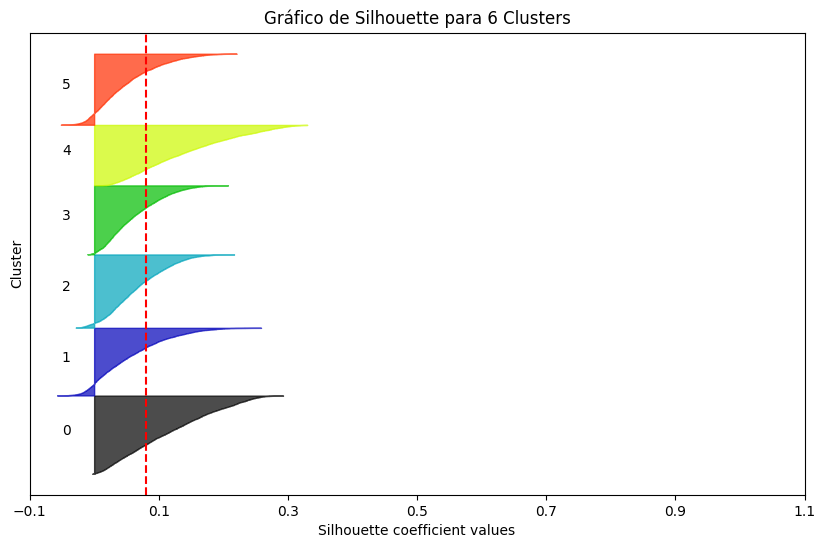

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Calcular el Silhouette Score medio
silhouette_avg = silhouette_score(X_train_flattened, cluster_labels)
print(f"Silhouette Score medio: {silhouette_avg}")

# Obtener los valores de Silhouette para cada muestra
sample_silhouette_values = silhouette_samples(X_train_flattened, cluster_labels)

# Graficar el Silhouette Score
plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(k):
    # Agregar los valores de silhouette para cada cluster (y ordenarlos)
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    # Definir el rango de y en donde se colocarán estos puntos
    y_upper = y_lower + len(ith_cluster_silhouette_values)

    # Elegir un color para el cluster
    color = plt.cm.nipy_spectral(float(i) / k)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Etiquetar el cluster en el medio
    plt.text(-0.05, y_lower + 0.5 * len(ith_cluster_silhouette_values), str(i))

    # Calcular el nuevo y_lower para el siguiente plot
    y_lower = y_upper + 10  # Dejar espacio en blanco entre los clusters

# Etiquetas y límites del gráfico
plt.title(f"Gráfico de Silhouette para {k} Clusters")
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])  # Eliminar ticks en y
plt.xticks(np.arange(-0.1, 1.1, 0.2))

plt.show()

In [8]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_train_normalized)
                for k in range(1, 11)]
				
silhouette_scores = [silhouette_score(X_train_normalized, model.labels_)
                     for model in kmeans_per_k[1:]]

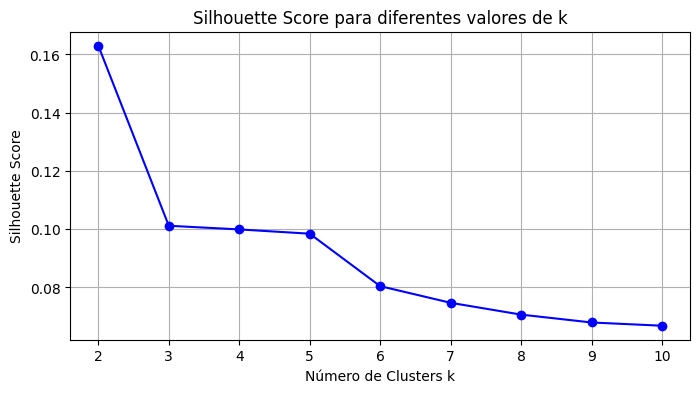

In [9]:
# Crear la gráfica
k_values = range(2, 11)  # Valores de k desde 2 hasta 9
plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_scores, marker='o', color='blue')  # Usar k_values en lugar de k
plt.xlabel('Número de Clusters k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para diferentes valores de k')
plt.grid(True)  # Añadir grid para una mejor lectura

# Mostrar la gráfica
plt.show()


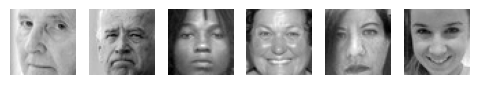

In [10]:
import matplotlib.pyplot as plt
# Visualización de las imágenes normalizadas
plt.figure(figsize=(10, 5))

# Imprimir las primeras 50 imágenes representativas normalizadas
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(5, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(48, 48), cmap="gray")  # "gray" mapa de colores
    plt.axis('off')

plt.show()


In [11]:
#y_train[idxs]

array([3, 4, 3, 2, 1, 2])

In [12]:
# Acceder a las etiquetas representativas
y_representative_digits = [3, 4, 3, 2, 1, 2]

### Entrenar el modelo de regresión logística

`LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=10000, random_state=42)`: Define el modelo de regresión logística con los siguientes parámetros:
- **multi_class="ovr"**: Utiliza la estrategia "One-vs-Rest", donde se entrena un clasificador para cada clase contra las demás.
- **solver="lbfgs"**: Utiliza el algoritmo de optimización lbfgs, adecuado para problemas con muchas clases.
- **max_iter=10000**: Define el número máximo de iteraciones para garantizar que el algoritmo converja.
- **random_state=42**: Establece una semilla para que los resultados sean reproducibles.

`%time log_reg2.fit(X_train_flattened, y_train)`: Entrena el modelo utilizando las imágenes aplanadas del conjunto de entrenamiento (`X_train_flattened`) y sus etiquetas (`y_train`). El comando `%time` mide cuánto tiempo toma el entrenamiento.

### Evaluar el modelo

`log_reg2.score(X_test_flattened, y_test)`: Evalúa el modelo en el conjunto de prueba (`X_test_flattened` y `y_test`). La función `score` calcula la precisión, es decir, el porcentaje de predicciones correctas en el conjunto de prueba.

`print(f"Precisión del modelo en el conjunto de prueba: {score}")`: Imprime la precisión obtenida, lo que indica qué tan bien está funcionando el modelo en los datos de prueba.

### Resumen
Este código entrena un modelo de regresión logística utilizando imágenes aplanadas y evalúa su precisión en el conjunto de prueba. El objetivo es clasificar correctamente las imágenes de acuerdo con las etiquetas proporcionadas.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Aplanar las imágenes representativas
X_representative_digits_flat = X_representative_digits.reshape(X_representative_digits.shape[0], -1)  # De (n_samples, 48, 48) a (n_samples, 48*48)

# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

# Entrenar el modelo de regresión logística usando OneVsRestClassifier
log_reg2 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=10000, random_state=42)
%time log_reg2.fit(X_train_scaled, y_train)

# Evaluar el modelo
score = log_reg2.score(X_test_scaled, y_test)
print(f"Precisión del modelo en el conjunto de prueba: {score}")


d:\UNIVERSIDAD\6to Semestre\IA\PYTHON\env\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


CPU times: total: 5min 22s
Wall time: 2min 37s
Precisión del modelo en el conjunto de prueba: 0.3407603890362511


### Entrenar el modelo de regresión logística con imágenes representativas

`log_reg2 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=10000, random_state=42)`: Define un modelo de regresión logística con los siguientes parámetros:
- **multi_class="ovr"**: Utiliza la estrategia "One-vs-Rest", donde se entrena un clasificador para cada clase contra las demás.
- **solver="lbfgs"**: Utiliza el algoritmo de optimización lbfgs, adecuado para problemas con muchas clases.
- **max_iter=10000**: Define el número máximo de iteraciones para garantizar la convergencia del algoritmo.
- **random_state=42**: Establece una semilla para obtener resultados reproducibles.

`%time log_reg2.fit(X_representative_digits_flat, y_representative_digits)`: Entrena el modelo utilizando las imágenes representativas aplanadas (`X_representative_digits_flat`) y sus etiquetas (`y_representative_digits`). La línea `%time` mide cuánto tiempo tarda en ejecutarse el proceso de entrenamiento.

### Evaluar el modelo en el conjunto de prueba

`log_reg2.score(X_test_flattened, y_test)`: Evalúa el modelo entrenado en el conjunto de prueba (`X_test_flattened` y `y_test`). Devuelve la **precisión** del modelo, que mide el porcentaje de predicciones correctas en los datos de prueba.

### Resumen
Este código entrena un modelo de regresión logística usando solo las imágenes representativas obtenidas mediante el algoritmo K-Means y evalúa su precisión en el conjunto de prueba. Este enfoque es más eficiente ya que se utilizan menos datos para el entrenamiento, pero aún se evalúa el rendimiento en un conjunto completo de prueba.

Entrena el modelo usando imágenes representativas seleccionadas mediante KMeans, lo que garantiza que las imágenes de entrenamiento sean más diversas y representen mejor las clases. Esto puede conducir a un modelo más equilibrado y capaz de generalizar mejor.

In [14]:
log_reg2 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=10000, random_state=42)
%time log_reg2.fit(X_representative_digits_flat, y_representative_digits)
log_reg2.score(X_test_flattened, y_test)

d:\UNIVERSIDAD\6to Semestre\IA\PYTHON\env\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


CPU times: total: 46.9 ms
Wall time: 163 ms


0.21007957559681698

Entrena el modelo con las primeras 50 imágenes del conjunto de entrenamiento, sin ninguna selección especial. Esto puede ser rápido, pero podría dar lugar a un modelo con menor capacidad de generalización debido a la falta de diversidad en las imágenes de entrenamiento.

In [15]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=10000, random_state=42)
%time log_reg.fit(X_train_flattened[:50], y_train[:50])
log_reg.score(X_test_flattened, y_test)

d:\UNIVERSIDAD\6to Semestre\IA\PYTHON\env\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


CPU times: total: 125 ms
Wall time: 297 ms


0.23536693191865607

Entrena el modelo con las primeras 50 imágenes del conjunto de entrenamiento, sin ninguna selección especial. Esto puede ser rápido, pero podría dar lugar a un modelo con menor capacidad de generalización debido a la falta de diversidad en las imágenes de entrenamiento.

## Propagación de etiquetas

- `np.empty(len(X_train_flattened))`: Crea un array vacío llamado `y_train_propagated` con el mismo tamaño que el conjunto de datos `X_train_flattened`. Aquí es donde se almacenarán las etiquetas propagadas.

- Aquí se itera sobre cada cluster identificado por el algoritmo `KMeans` (el cual está implícito y debió ejecutarse previamente).

  - `kmeans.labels_ == i`: Esto selecciona las imágenes que pertenecen al cluster `i`.
  - `y_representative_digits[i]`: Para cada cluster `i`, asigna la etiqueta de la imagen representativa de ese cluster a todas las imágenes que pertenecen a ese cluster. Es decir, todas las imágenes en el cluster reciben la misma etiqueta que la imagen representativa del cluster.

### Propagación de etiquetas

Se está propagando la etiqueta de la imagen representativa de cada cluster a todas las imágenes dentro del mismo cluster, suponiendo que todas las imágenes en un cluster comparten la misma clase.


In [16]:
y_train_propagated = np.empty(len(X_train_flattened))
for i in range(k):
  y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

## Entrenamiento del modelo con las etiquetas propagadas

- `y_train_propagated[:1000]`: El modelo de regresión logística se entrena usando las primeras 1000 imágenes aplanadas del conjunto de entrenamiento (`X_train_flattened[:1000]`) y las etiquetas propagadas (`y_train_propagated[:1000]`).

- `%time`: Mide el tiempo que tarda en entrenarse el modelo.


## Resumen

Este código utiliza un proceso de propagación de etiquetas basado en clusters, donde las imágenes de cada cluster reciben la etiqueta de la imagen representativa del cluster.

### Tamaño del conjunto de entrenamiento

Este código entrena con 1000 imágenes, mientras que los códigos anteriores entrenan con solo 50 imágenes o con imágenes representativas.

### Etiquetas inferidas

Este código utiliza etiquetas inferidas para las imágenes, lo que puede introducir un margen de error si los clusters no son perfectos, pero permite entrenar con un mayor número de datos.


In [17]:
log_reg4 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=10000, random_state=42)
%time log_reg4.fit(X_train_flattened[:1000], y_train_propagated[:1000])
log_reg4.score(X_test_flattened, y_test)

d:\UNIVERSIDAD\6to Semestre\IA\PYTHON\env\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


CPU times: total: 19.4 s
Wall time: 22.8 s


0.1964633068081344

APRENDIZAJE ACTIVO

## ¿Qué está haciendo este código?

Este código implementa una estrategia de selección de muestras basada en la incertidumbre, que es un concepto central en el aprendizaje activo. El proceso que sigue es:

1. El modelo predice las probabilidades de pertenencia de cada imagen a las distintas clases.
2. Se identifica la clase más probable para cada imagen.
3. Se calcula el nivel de confianza del modelo en su predicción, utilizando la probabilidad de la clase más probable.
4. Se ordenan las imágenes según el nivel de confianza (de menor a mayor).
5. Finalmente, se seleccionan las 10 imágenes donde el modelo tiene menos confianza en sus predicciones.

## ¿Cómo funciona el aprendizaje activo aquí?

El aprendizaje activo se basa en la idea de que, en lugar de etiquetar y entrenar con todas las imágenes disponibles, es más eficiente seleccionar solo aquellas en las que el modelo tiene menos confianza y que tienen mayor probabilidad de mejorar su rendimiento. 

Las imágenes seleccionadas en este código serían aquellas en las que el modelo es más incierto, y en un flujo típico de aprendizaje activo, estas imágenes se pasarían a un experto para su etiquetado, y luego se usarían para reentrenar el modelo, mejorando su precisión.

In [18]:
probas = log_reg4.predict_proba(X_train_flattened[:1000])
labels_ixs = np.argmax(probas, axis=1)
labels = np.array([proba[ix] for proba, ix in zip(probas, labels_ixs)])
sorted_ixs = np.argsort(labels)
labels[sorted_ixs[:10]]

array([0.92528253, 0.99952065, 0.99956942, 0.99960011, 0.99961544,
       0.99969993, 0.99970084, 0.99972347, 0.99972797, 0.99973006])

Este código selecciona las k imágenes que el modelo de regresión logística considera más difíciles de clasificar. Estas imágenes corresponden a aquellas donde el modelo tiene menor confianza en su predicción. El propósito de esta selección es identificar las imágenes más inciertas, que podrían ser etiquetadas manualmente para luego mejorar el modelo en un escenario de aprendizaje activo.

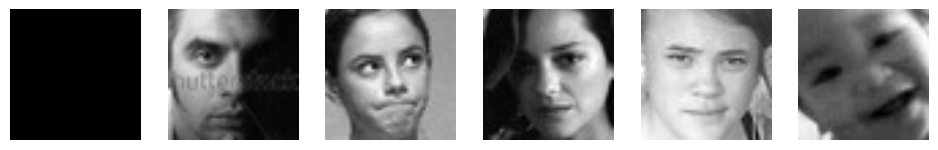

In [19]:
# Selección de las imágenes más inciertas
X_lowest = X_train_flattened[:1000][sorted_ixs[:k]]

plt.figure(figsize=(20, 20))
for index, img in enumerate(X_lowest):
    plt.subplot(10, 10, index + 1)  # Ajustar el número de filas basado en k
    plt.imshow(img.reshape(48, 48), cmap="gray", interpolation="bilinear")
    plt.axis('off')

plt.show()

Este código selecciona las etiquetas de las k imágenes donde el modelo tiene menos confianza en su predicción. Como estas son las imágenes más inciertas, es probable que las etiquetas reales sean importantes para corregir las predicciones del modelo. En un escenario de aprendizaje activo, estas etiquetas podrían ser las que se utilizan para reentrenar el modelo con imágenes difíciles, lo que mejora su capacidad para generalizar.

In [20]:
#y_train[:1000][sorted_ixs[:k]]

array([3, 3, 0, 4, 1, 2])

In [21]:
y_lowest = [3, 3, 0, 4, 1, 2]
y_lowest

array([3, 3, 0, 4, 1, 2])

## Copia de las etiquetas propagadas

- Inicialmente, el código copia las primeras 1000 etiquetas propagadas a una nueva variable `y_train2`.

## Actualización de las etiquetas inciertas

- Luego, reemplaza las etiquetas de las k imágenes más inciertas (que previamente se identificaron) con sus etiquetas reales (almacenadas en `y_lowest`).

El objetivo es mejorar las etiquetas que fueron propagadas (y posiblemente incorrectas) utilizando las etiquetas verdaderas de las imágenes más inciertas. Esto puede ayudar al modelo a aprender de manera más precisa, ya que ahora tiene las etiquetas correctas para los ejemplos más difíciles.


## ¿Por qué es útil?

En aprendizaje activo, el objetivo es seleccionar ejemplos en los que el modelo tiene más incertidumbre y actualizar el conjunto de datos con las etiquetas correctas para esos ejemplos. De esta manera, el modelo puede mejorar su rendimiento general al aprender de los ejemplos que le resultan más difíciles.

### Propagación de etiquetas

Inicialmente, las etiquetas de las imágenes se propagaron utilizando KMeans, pero algunas de estas etiquetas pueden haber sido incorrectas.

### Actualización con etiquetas reales

Este código selecciona las imágenes en las que el modelo tiene menos confianza (las más inciertas) y actualiza sus etiquetas con las etiquetas reales.


In [22]:
y_train2 = y_train_propagated[:1000].copy()
y_train2[sorted_ixs[:k]] = y_lowest

Este paso es crucial porque, después de haber identificado y corregido las etiquetas más inciertas, entrenas el modelo con un conjunto de datos más confiable. La estrategia de aprendizaje activo que has implementado asegura que el modelo entrene con ejemplos difíciles pero correctamente etiquetados, lo que puede llevar a una mejora significativa en el rendimiento final del modelo.

In [23]:
log_reg5 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=10000, random_state=42)
%time log_reg5.fit(X_train_flattened[:1000], y_train2)
log_reg5.score(X_test_flattened, y_test)

d:\UNIVERSIDAD\6to Semestre\IA\PYTHON\env\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


CPU times: total: 19.3 s
Wall time: 25.6 s


0.19929266136162688

¿Por qué cambiar de modelo?
En este tipo de tarea, los modelos tradicionales como la regresión logística o los algoritmos de K-Means no suelen ser la mejor opción, ya que no capturan adecuadamente las características espaciales de las imágenes.

Limitaciones de los modelos tradicionales:
Regresión Logística y otros modelos lineales:
Estos modelos tratan cada píxel como una característica independiente, sin aprovechar las relaciones espaciales entre los píxeles.
No tienen capacidad para detectar patrones complejos, como bordes, texturas, o formas, que son características cruciales en las imágenes.
K-Means:
Este es un algoritmo de clustering que funciona bien en datos no supervisados, pero no está diseñado para manejar datos de imágenes de manera eficiente. El clustering puede agrupar imágenes de manera incorrecta si no se capturan bien los patrones visuales.